In [1]:
import numpy as np
from scipy.special import hankel1 as besselh
from scipy.special import iv as besseli
from scipy.special import kv as besselk
import scipy.integrate as integrate
import scipy.linalg as linalg
import matplotlib.pyplot as plt
from math import sqrt, cosh, cos, sinh, sin, pi
from scipy.optimize import newton, minimize_scalar
from RM3_constants import *
from multi_equations import *
import pandas as pd


In [2]:
# CREATING THE A MATRIX

# Number of terms in approx of each region.
# All computations assume at least 2 regions.
NMK = [8, 9, 11, 13, 12, 10]

size = NMK[0] + NMK[-1] + 2 * sum(NMK[1:len(NMK) - 1])
boundary_count = len(NMK) - 1

# Initialize the A matrix with zeros as well as b vector
A = np.zeros((size, size), dtype=complex)


###########################################################################
# Potential Matching

col = 0
row = 0
for bd in range(boundary_count):
    N = NMK[bd]
    M = NMK[bd + 1]
    if bd == (boundary_count - 1): # i-e boundary
        if bd == 0: # one cylinder
            for n in range(N):
                A[row + n][col + n] = (h - d[bd]) * R_1n(n, a[bd], bd)
                for m in range(M):
                    A[row + n][col + N + m] = - I_mk(n, m, bd) * Lambda_k(m, a[bd])
        else:
            for n in range(N):
                A[row + n][col + n] = (h - d[bd]) * R_1n(n, a[bd], bd)
                A[row + n][col + N + n] = (h - d[bd]) * R_2n(n, a[bd], bd)
                for m in range(M):
                    A[row + n][col + 2*N + m] = - I_mk(n, m, bd) * Lambda_k(m, a[bd])
        row += N
            
    elif bd == 0:
        left_diag = d[bd] > d[bd + 1] # which of the two regions gets diagonal entries
        if left_diag:
            for n in range(N):
                A[row + n][col + n] = (h - d[bd]) * R_1n(n, a[bd], bd)
                for m in range(M):
                    A[row + n][col + N + m] = - I_nm(n, m, bd) * R_1n(m, a[bd], bd + 1)
                    A[row + n][col + N + M + m] = - I_nm(n, m, bd) * R_2n(m, a[bd], bd + 1)
            row += N
        else:
            for m in range(M):
                for n in range(N):
                    A[row + m][col + n] = I_nm(n, m, bd) * R_1n(n, a[bd], bd)
                A[row + m][col + N + m] = - (h - d[bd + 1]) * R_1n(m, a[bd], bd + 1)
                A[row + m][col + N + M + m] = - (h - d[bd + 1]) * R_2n(m, a[bd], bd + 1)
            row += M
        col += N
    else: # i-i boundary
        left_diag = d[bd] > d[bd + 1] # which of the two regions gets diagonal entries
        if left_diag:
            for n in range(N):
                A[row + n][col + n] = (h - d[bd]) * R_1n(n, a[bd], bd)
                A[row + n][col + N + n] = (h - d[bd]) * R_2n(n, a[bd], bd)
                for m in range(M):
                    A[row + n][col + 2*N + m] = - I_nm(n, m, bd) * R_1n(m, a[bd], bd + 1)
                    A[row + n][col + 2*N + M + m] = - I_nm(n, m, bd) * R_2n(m, a[bd], bd + 1)
            row += N
        else:
            for m in range(M):
                for n in range(N):
                    A[row + m][col + n] = I_nm(n, m, bd) * R_1n(n, a[bd], bd)
                    A[row + m][col + N + n] = I_nm(n, m, bd) * R_2n(n, a[bd], bd)
                A[row + m][col + 2*N + m] = - (h - d[bd + 1]) * R_1n(m, a[bd], bd + 1)
                A[row + m][col + 2*N + M + m] = - (h - d[bd + 1]) * R_2n(m, a[bd], bd + 1)
            row += M
        col += 2 * N


###########################################################################
# Velocity Matching 

col = 0
for bd in range(boundary_count):
    N = NMK[bd]
    M = NMK[bd + 1]
    if bd == (boundary_count - 1): # i-e boundary
        if bd == 0: # one cylinder
            for m in range(M):
                for n in range(N):
                    A[row + m][col + n] = - I_mk(n, m, bd) * diff_R_1n(n, a[bd], bd)
                A[row + m][col + N + m] = h * diff_Lambda_k(m, a[bd])
        else:
            for m in range(M):
                for n in range(N):
                    A[row + m][col + n] = - I_mk(n, m, bd) * diff_R_1n(n, a[bd], bd)
                    A[row + m][col + N + n] = - I_mk(n, m, bd) * diff_R_2n(n, a[bd], bd)
                A[row + m][col + 2*N + m] = h * diff_Lambda_k(m, a[bd])
        row += N
            
    elif bd == 0:
        left_diag = d[bd] < d[bd + 1] # which of the two regions gets diagonal entries
        if left_diag:
            for n in range(N):
                A[row + n][col + n] = - (h - d[bd]) * diff_R_1n(n, a[bd], bd)
                for m in range(M):
                    A[row + n][col + N + m] = I_nm(n, m, bd) * diff_R_1n(m, a[bd], bd + 1)
                    A[row + n][col + N + M + m] = I_nm(n, m, bd) * diff_R_2n(m, a[bd], bd + 1)
            row += N
        else:
            for m in range(M):
                for n in range(N):
                    A[row + m][col + n] = - I_nm(n, m, bd) * diff_R_1n(n, a[bd], bd)
                A[row + m][col + N + m] = (h - d[bd + 1]) * diff_R_1n(m, a[bd], bd + 1)
                A[row + m][col + N + M + m] = (h - d[bd + 1]) * diff_R_2n(m, a[bd], bd + 1)
            row += M
        col += N
    else: # i-i boundary
        left_diag = d[bd] < d[bd + 1] # which of the two regions gets diagonal entries
        if left_diag:
            for n in range(N):
                A[row + n][col + n] = - (h - d[bd]) * diff_R_1n(n, a[bd], bd)
                A[row + n][col + N + n] = - (h - d[bd]) * diff_R_2n(n, a[bd], bd)
                for m in range(M):
                    A[row + n][col + 2*N + m] = I_nm(n, m, bd) * diff_R_1n(m, a[bd], bd + 1)
                    A[row + n][col + 2*N + M + m] = I_nm(n, m, bd) * diff_R_2n(m, a[bd], bd + 1)
            row += N
        else:
            for m in range(M):
                for n in range(N):
                    A[row + m][col + n] = - I_nm(n, m, bd) * diff_R_1n(n, a[bd], bd)
                    A[row + m][col + N + n] = - I_nm(n, m, bd) * diff_R_2n(n, a[bd], bd)
                A[row + m][col + 2*N + m] = (h - d[bd + 1]) * diff_R_1n(m, a[bd], bd + 1)
                A[row + m][col + 2*N + M + m] = (h - d[bd + 1]) * diff_R_2n(m, a[bd], bd + 1)
            row += M
        col += 2 * N


###########################################################################
if False:
    
 rows, cols = np.nonzero(A)
 plt.figure(figsize=(6, 6))
 plt.scatter(cols, rows, color='blue', marker='o', s=100) 
 plt.gca().invert_yaxis() 
 plt.xticks(range(A.shape[1]))
 plt.yticks(range(A.shape[0]))

 cols = [NMK[0]]
 for i in range(1, boundary_count):
    cols.append(cols[-1] + NMK[i])
    cols.append(cols[-1] + NMK[i])
 cols.append(cols[-1] + NMK[-1])

 for val in cols:
    plt.axvline(val-0.5, color='black', linestyle='-', linewidth=1) 
    plt.axhline(val-0.5, color='black', linestyle='-', linewidth=1) 

 # for y in range(0, A.shape[0], 3):
    # plt.axhline(y-0.5, color='black', linestyle='-', linewidth=1) 

 plt.grid(True)
 plt.title('Non-Zero Entries of the Matrix')
 plt.xlabel('Column Index')
 plt.ylabel('Row Index')
 plt.show()
 # plt.imshow(np.real(A))
 # plt.colorbar()
 # print(A[:3,:3])
 # print(R_1n_2(3, a1) * A_nm(1, 3))
 # print(R_2n_2(3, a1) * A_nm(1, 3))


In [3]:
b = np.zeros(size, dtype=complex)

index = 0

# potential matching
for boundary in range(boundary_count):
    if boundary == (boundary_count - 1): # i-e boundary
        for n in range(NMK[-2]):
            b[index] = b_potential_end_entry(n, boundary)
            index += 1
    else: # i-i boundary
        for n in range(NMK[boundary + (d[boundary] < d[boundary + 1])]): # iterate over eigenfunctions for smaller h-d
            b[index] = b_potential_entry(n, boundary)
            index += 1

# velocity matching
for boundary in range(boundary_count):
    if boundary == (boundary_count - 1): # i-e boundary
        for n in range(NMK[-1]):
            b[index] = b_velocity_end_entry(n, boundary)
            index += 1
    else: # i-i boundary
        for n in range(NMK[boundary + (d[boundary] > d[boundary + 1])]): # iterate over eigenfunctions for larger h-d
            b[index] = b_velocity_entry(n, boundary)
            index += 1


In [4]:
X = linalg.solve(A,b)

/var/folders/38/fxny0zwd2vqfvtmnbr2_n1pc0000gn/T/ipykernel_96589/2932172903.py:1: LinAlgWarning: Ill-conditioned matrix (rcond=9.32794e-28): result may not be accurate.
  X = linalg.solve(A,b)


In [5]:
Cs = []
row = 0
Cs.append(X[:NMK[0]])
row += NMK[0]
for i in range(1, boundary_count):
    Cs.append(X[row: row + NMK[i] * 2])
    row += NMK[i] * 2
Cs.append(X[row:])

#phi_h_n_i1 = lambda n, r, z:  (C_1n_1s[n] * R_1n(n, r, 0)) * Z_n_i(n, z, 0)
#phi_h_m_i2 = lambda m, r, z: (C_1n_2s[m] * R_1n(m, r, 1) + C_2n_2s(m) * R_2n(m, r, 1)) * Z_n_i(m, z, 1)
#phi_e_k = lambda k, r, z: B_ks[k] * Lambda_k(k, r) * Z_n_e(k, z)


def phi_h_n_inner_func(n, r, z):
    return (Cs[0][n] * R_1n(n, r, 0)) * Z_n_i(n, z, 0)

def phi_h_m_i_func(i, m, r, z):
    return (Cs[i][m] * R_1n(m, r, i) + Cs[i][NMK[i] + m] * R_2n(m, r, i)) * Z_n_i(m, z, i)

def phi_e_k_func(k, r, z):
    return Cs[-1][k] * Lambda_k(k, r) * Z_n_e(k, z)

#phi_h_n_i1s = np.vectorize(phi_h_n_i1_func, excluded=['n'], signature='(),(),()->()')
#phi_h_m_i2s = np.vectorize(phi_h_m_i2_func, excluded=['m'], signature='(),(),()->()')
#phi_e_ks = np.vectorize(phi_e_k_func, excluded=['k'], signature='(),(),()->()')


r_vec = lambda spatial_res: np.linspace(2 * a[-1] / spatial_res, 2*a[-1], spatial_res)
z_vec = lambda spatial_res: np.linspace(-h, 0, spatial_res)
R, Z = np.meshgrid(r_vec(spatial_res=50), z_vec(spatial_res=50))
 

regions = []
regions.append((R <= a[0]) & (Z < -d[0]))
for i in range(1, boundary_count):
    regions.append((R > a[i-1]) & (R <= a[i]) & (Z < -d[i]))
regions.append(R > a[-1])

# region_body = ~region1 & ~region2 & ~regione


phi = np.full_like(R, np.nan + np.nan*1j, dtype=complex) 
phiH = np.full_like(R, np.nan + np.nan*1j, dtype=complex) 
phiP = np.full_like(R, np.nan + np.nan*1j, dtype=complex) 

for n in range(NMK[0]):
    temp_phiH = phi_h_n_inner_func(n, R[regions[0]], Z[regions[0]])
    phiH[regions[0]] = temp_phiH if n == 0 else phiH[regions[0]] + temp_phiH

for i in range(1, boundary_count):
    for m in range(NMK[i]):
        temp_phiH = phi_h_m_i_func(i, m, R[regions[i]], Z[regions[i]])
        phiH[regions[i]] = temp_phiH if m == 0 else phiH[regions[i]] + temp_phiH

for k in range(NMK[-1]):
    temp_phiH = phi_e_k_func(k, R[regions[-1]], Z[regions[-1]])
    phiH[regions[-1]] = temp_phiH if k == 0 else phiH[regions[-1]] + temp_phiH

phi_p_i_vec = np.vectorize(phi_p_i)

phiP[regions[0]] = phi_p_i_vec(d[0], R[regions[0]], Z[regions[0]])
for i in range(1, boundary_count):
    phiP[regions[i]] = phi_p_i_vec(d[i], R[regions[i]], Z[regions[i]])
phiP[regions[-1]] = 0

phi = phiH + phiP


In [ ]:
#indicate if the region is slanted or not
slant = [False, False, False, False, False]

hydro_terms = np.zeros((size - NMK[-1]), dtype=complex)
vel_z = np.zeros(len(NMK)-1, dtype=complex)

col = 0
region_indx = 0
for n in range(NMK[0]):
    if slant[0]:
        #need definition
        pass 
    else:
        hydro_terms[n] = int_R_1n(0, n)* X[n] * z_n_d(n)
col += NMK[0]
region_indx += 1
for i in range(1, boundary_count):
    M = NMK[i]
    if slant[i]:
        #bottom_corner
        phi_corner_H = sum(phi_h_m_i_func(i, n, a[i-1], -d[i-1]) for n in range(NMK[1]))
        phi_corner_P = phi_p_i(d[i], a[i-1], -d[i-1])
        phi_bttm_corner = phi_corner_H + phi_corner_P

        #top_corner
        phi_corner_H = sum(phi_h_m_i_func(i, n, a[i], -d[i]) for n in range(NMK[1]))
        phi_corner_P = phi_p_i(d[i], a[i], -d[i])
        phi_top_corner = phi_corner_H + phi_corner_P
        #slant velocity z component approximation
        vel_z[i] = (phi_top_corner - phi_bttm_corner)*(d[i-1]-d[i])/(abs(d[i-1]-d[i])**2+(a[i]-a[i-1])**2)
        for m in range(M):
            hydro_terms[col + m] = vel_z[i]*int_R_1n(i, m)* X[col + m] * z_n_d(m)
            hydro_terms[col + M + m] = vel_z[i]*int_R_2n(i, m)* X[col + M + m] * z_n_d(m)
    else:
        for m in range(M):
            hydro_terms[col + m] = int_R_1n(i, m)* X[col + m] * z_n_d(m)
            hydro_terms[col + M + m] = int_R_2n(i, m)* X[col + M + m] * z_n_d(m)
    col += 2 * M
    region_indx += 1

hydro_p_terms = np.zeros(boundary_count, dtype=complex)
for i in range(boundary_count):
    if slant[i]:
        hydro_p_terms[i] = vel_z[i]*int_phi_p_i_no_coef(i)
    else:
        hydro_p_terms[i] = int_phi_p_i_no_coef(i)

#when i2 is heaving
hydro_coef =2*pi*(sum(hydro_terms) + sum(hydro_p_terms))
hydro_coef_real = hydro_coef.real
hydro_coef_imag = hydro_coef.imag/omega


hydro_coef_nondim = h**3/(a[-1]**3 * pi)*hydro_coef

print("real", hydro_coef_real)
print("imag", hydro_coef_imag)
print(hydro_coef_nondim)


real 4.674257425898636
imag 1.9186740087551732
(1.2259607980118221+1.0064568142375319j)


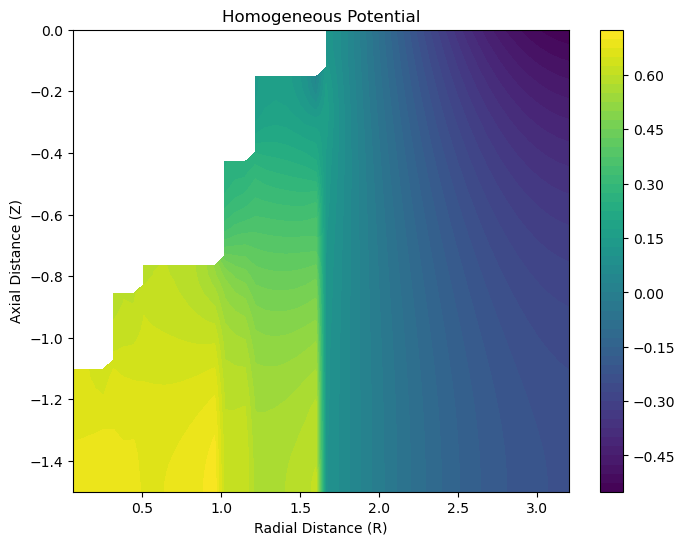

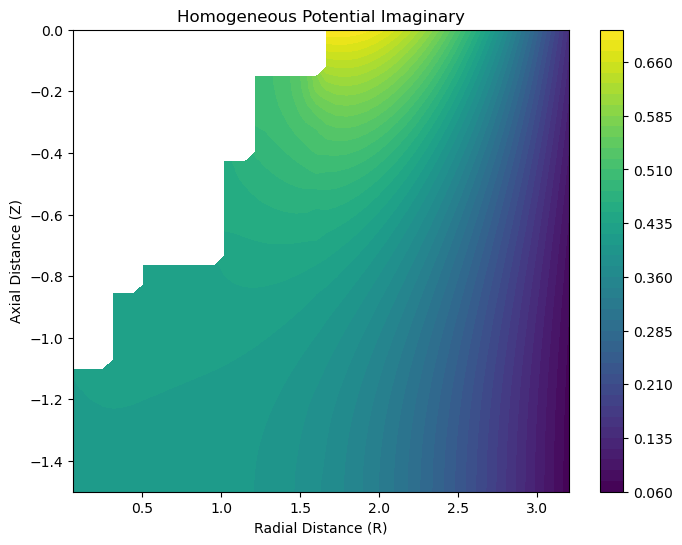

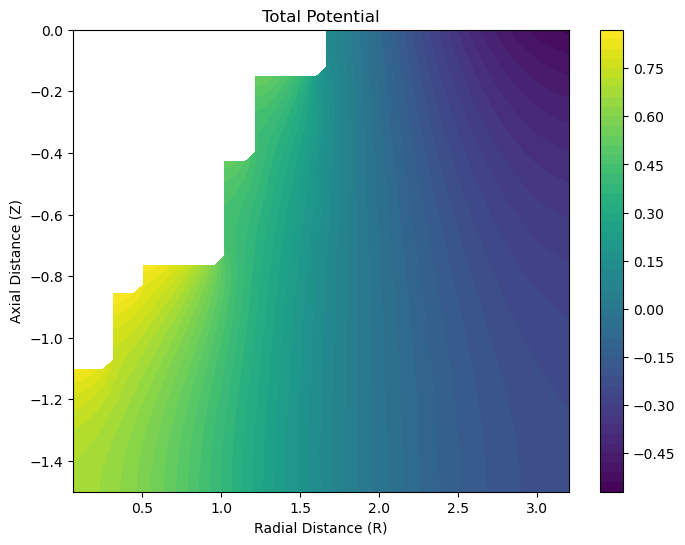

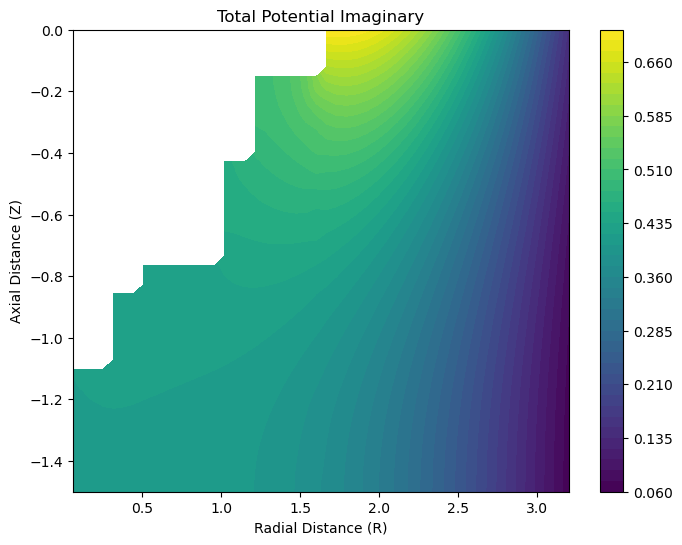

In [10]:
def plot_potential(field, R, Z, title):
    plt.figure(figsize=(8, 6))
    plt.contourf(R, Z, field, levels=50, cmap='viridis')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('Radial Distance (R)')
    plt.ylabel('Axial Distance (Z)')
    plt.show()

def plot_velocity(v_r, v_z, R, Z):
    plt.figure(figsize=(8, 6))
    plt.streamplot(R, Z, v_r, v_z, color='magenta', density=2)
    plt.title('Velocity Field')
    plt.xlabel('Radial Distance (R)')
    plt.ylabel('Axial Distance (Z)')
    plt.show()

plot_potential(np.real(phiH), R, Z, 'Homogeneous Potential')
plot_potential(np.imag(phiH), R, Z, 'Homogeneous Potential Imaginary')

plot_potential(np.real(phi), R, Z, 'Total Potential')
plot_potential(np.imag(phi), R, Z, 'Total Potential Imaginary')
# print(phiH)
# print(phiH[region2])
# print(phiH[regione])
# plot_potential(np.real(phiP), R, Z, 'Particular Potential')

# print(np.real(phiP))

# plot_potential(np.real(v_r), R, Z, 'Radial Velocity')
# plot_potential(np.real(v_z), R, Z, 'Vertical Velocity')


In [ ]:
# Ignore code in following blocks. Not modified yet.

In [ ]:
def plot_matching(phi1, phi2, phi3, a1, a2, R, Z, title):
    plt.figure(figsize=(8, 6))
    mask1 = R <= a1
    mask2 = (R > a1) & (R <= a2)
    mask3 = R > a2

    # Create a combined field based on regions
    combined_field = np.zeros_like(R)
    combined_field[mask1] = phi1[mask1]
    combined_field[mask2] = phi2[mask2]
    combined_field[mask3] = phi3[mask3]

    plt.contourf(R, Z, combined_field, levels=50, cmap='viridis')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('Radial Distance (R)')
    plt.ylabel('Axial Distance (Z)')
    plt.show()


In [ ]:
plot_potential(phiH, R, Z, 'Homogeneous Potential')
plot_potential(phiP, R, Z, 'Particular Potential')
plot_potential(phi, R, Z, 'Total Potential')
# plot_potential(v_r, R, Z, 'Radial Velocity')
# plot_potential(v_z, R, Z, 'Vertical Velocity')
# plot_velocity(np.real(v_r), np.real(v_z), R, Z)

# # Assuming phi_p_i1_num, phi_p_i2_num, zeros are meant to show some regions with no data (using np.zeros_like(R))
# plot_matching(phi_i1_num, phi_i2_num, phi_e_num, a1_num, a2_num, R, Z, 'Potential')
# plot_matching(phi_h_i1_num, phi_h_i2_num, phi_e_num, a1_num, a2_num, R, Z, 'Homogeneous Potential')
# plot_matching(phi_p_i1_num, phi_p_i2_num, np.zeros_like(R), a1_num, a2_num, R, Z, 'Particular Potential')
# plot_matching(v_1_r_num, v_2_r_num, v_e_r_num, a1_num, a2_num, R, Z, 'Radial Velocity')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_potential(phi, R, Z, region_body, name):
    minphi = np.nanmin(np.real(phi))
    maxphi = np.nanmax(np.real(phi))

    num_levels = 30
    if minphi < 0:
        levels = np.linspace(minphi, maxphi, num_levels)
    else:
        levels = np.linspace(minphi, maxphi, num_levels)

    plt.figure()
    plt.subplot(121)
    contour_real = plt.contourf(R, Z, np.real(phi), levels)
    plt.clabel(contour_real)
    plt.xlabel('R')
    plt.ylabel('Z')
    plt.title(name + ' - Real')
    plt.colorbar()

    imag_phi = np.imag(phi)
    if len(np.unique(imag_phi)) > 1:
        imag_phi[region_body] = np.nan
        plt.subplot(122)
        contour_imag = plt.contourf(R, Z, imag_phi, num_levels)
        plt.clabel(contour_imag)
        plt.xlabel('R')
        plt.ylabel('Z')
        plt.title(name + ' - Imaginary')
        plt.colorbar()

def plot_matching(phi1, phi2, phie, a1, a2, R, Z, name):
    idx_a1 = np.argmin(np.abs(R - a1), axis=1)
    phi1_a1 = np.abs(phi1[np.arange(len(idx_a1)), idx_a1])
    phi2_a1 = np.abs(phi2[np.arange(len(idx_a1)), idx_a1])

    idx_a2 = np.argmin(np.abs(R - a2), axis=1)
    phi2_a2 = np.abs(phi2[np.arange(len(idx_a2)), idx_a2])
    phie_a2 = np.abs(phie[np.arange(len(idx_a2)), idx_a2])

    plt.figure()
    plt.plot(Z[idx_a1], phi1_a1, 'r--', label=name + '_1 at a_1')
    plt.plot(Z[idx_a1], phi2_a1, 'm-', label=name + '_2 at a_1')
    plt.plot(Z[idx_a2], phi2_a2, 'b-', label=name + '_2 at a_2')
    plt.plot(Z[idx_a2], phie_a2, 'c--', label=name + '_e at a_2')
    plt.legend()
    plt.xlabel('Z')
    plt.ylabel('|' + name + '|')
    plt.title(name + ' Matching')

def plot_velocity(v_r, v_z, R, Z):
    v_tot = np.sqrt(v_r**2 + v_z**2)

    num_levels = 10
    levels = np.concatenate((np.logspace(1, 6, num_levels), np.arange(0, 21, 2)))

    plt.figure()
    contour_v = plt.contourf(R, Z, v_tot, levels)
    plt.clabel(contour_v)
    plt.xlabel('R')
    plt.ylabel('Z')
    plt.title('Velocity')
    plt.colorbar()
    plt.quiver(R, Z, v_r/v_tot, v_z/v_tot)

# Example usage:
# plot_potential(phi, R, Z, region_body, 'Potential')
# plot_matching(phi1, phi2, phie, a1, a2, R, Z, 'Matching')
# plot_velocity(v_r, v_z, R, Z)


In [ ]:
plot_potential(phiH,R,Z,region_body,'Homogeneous Potential')
plot_potential(phiP,R,Z,region_body,'Particular Potential')